HRV Analysis Results:
Mean Heart Rate (BPM): 78.67
SDNN (ms): 194.36
RMSSD (ms): 334.12
Total Beats Detected: 97


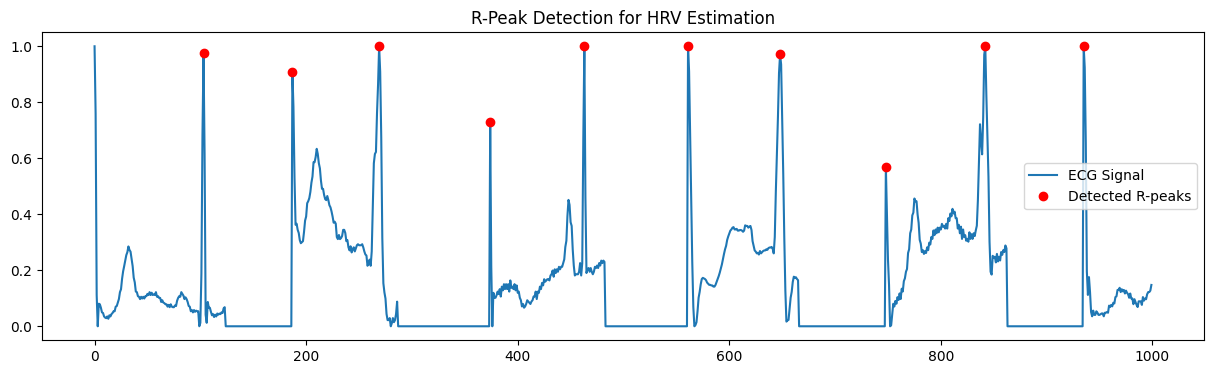

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def calculate_hrv_metrics(ecg_signal, fs=125):
    """
    Estimates HRV metrics from a continuous ECG signal.

    Parameters:
    - ecg_signal: 1D array of ECG amplitude values.
    - fs: Sampling frequency (MIT-BIH is typically 125Hz).

    Returns:
    - metrics: Dictionary containing Mean HR, SDNN, and RMSSD.
    - peaks: Indices of detected R-peaks.
    """
    # 1. R-Peak Detection
    # 'distance' ensures we don't pick up multiple peaks for one beat
    # 'height' filters out noise and smaller T-waves
    peaks, _ = find_peaks(ecg_signal, distance=fs*0.4, height=0.5)

    if len(peaks) < 2:
        return None, "Error: Not enough peaks detected."

    # 2. Calculate RR intervals in milliseconds
    # RR interval is the time between successive R-peaks
    rr_intervals = np.diff(peaks) / fs * 1000  # Convert to ms

    # 3. Calculate HRV Metrics
    mean_hr = 60000 / np.mean(rr_intervals)  # Beats per minute
    sdnn = np.std(rr_intervals)              # Standard deviation of RR intervals
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals)))) # Root Mean Square of Differences

    metrics = {
        "Mean Heart Rate (BPM)": round(mean_hr, 2),
        "SDNN (ms)": round(sdnn, 2),
        "RMSSD (ms)": round(rmssd, 2),
        "Total Beats Detected": len(peaks)
    }

    return metrics, peaks

# --- Example Usage with mitbih_test.csv ---

# Load your data
df = pd.read_csv('mitbih_test.csv', header=None)

# Since the CSV contains individual segments, we concatenate a few rows
# to simulate a continuous ECG signal for this demonstration.
simulated_signal = df.iloc[:50, :187].values.flatten()
fs = 125 # Standard sampling rate for this dataset

metrics, peaks = calculate_hrv_metrics(simulated_signal, fs)

print("HRV Analysis Results:")
for key, value in metrics.items():
    print(f"{key}: {value}")

# Plotting the results
plt.figure(figsize=(15, 4))
plt.plot(simulated_signal[:1000], label='ECG Signal')
plt.plot(peaks[peaks < 1000], simulated_signal[peaks[peaks < 1000]], "ro", label='Detected R-peaks')
plt.title("R-Peak Detection for HRV Estimation")
plt.legend()
plt.show()

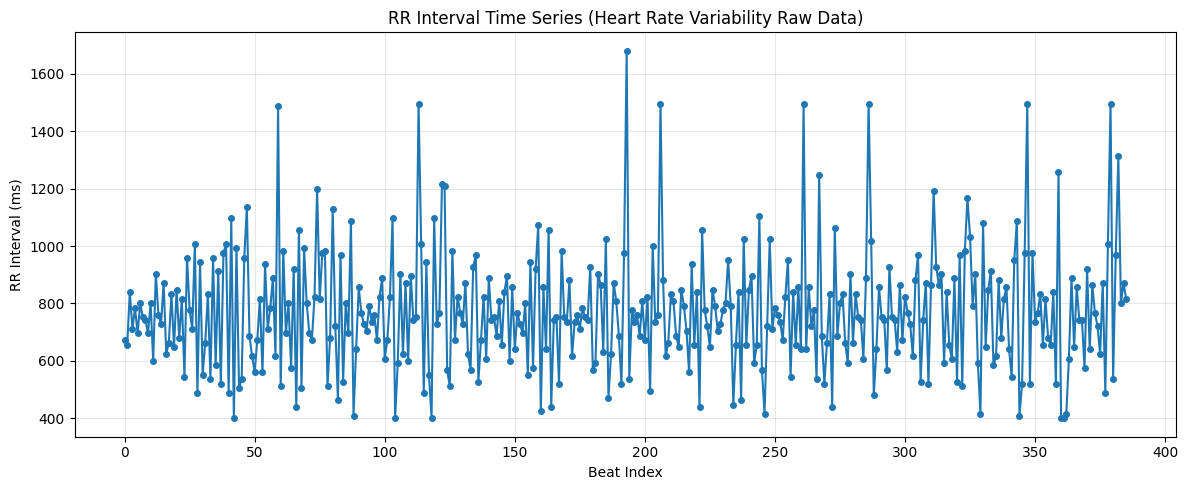

Total Beats Detected: 387
Mean RR Interval: 771.23 ms
SDNN (Standard Deviation): 206.42 ms


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def generate_rr_timeseries(file_path, sampling_rate=125, num_segments=200):
    """
    Loads ECG segments, creates a continuous signal, detects R-peaks,
    and returns the RR interval time series.
    """
    # 1. Load the dataset
    # mitbih_test.csv has no header; last column is the label
    df = pd.read_csv(file_path, header=None)

    # 2. Simulate a continuous signal
    # We concatenate the first 'num_segments' rows (187 samples each)
    ecg_data = df.iloc[:num_segments, :187].values.flatten()

    # 3. Detect R-peaks
    # distance: min samples between beats (approx 0.4s for 150bpm)
    # height: threshold to find the highest part of the QRS complex
    peaks, _ = find_peaks(ecg_data, distance=sampling_rate*0.4, height=0.5)

    # 4. Calculate RR intervals (in milliseconds)
    # diff(peaks) gives the number of samples between peaks
    rr_intervals = np.diff(peaks) / sampling_rate * 1000

    return ecg_data, peaks, rr_intervals

# --- Execution ---
fs = 125  # Frequency of MIT-BIH dataset
data_file = 'mitbih_test.csv'

signal, peaks, rr_series = generate_rr_timeseries(data_file, sampling_rate=fs)

# 5. Plot the RR Interval Time Series
plt.figure(figsize=(12, 5))
plt.plot(rr_series, marker='o', linestyle='-', color='tab:blue', markersize=4)
plt.title("RR Interval Time Series (Heart Rate Variability Raw Data)")
plt.xlabel("Beat Index")
plt.ylabel("RR Interval (ms)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("rr_interval_plot.png")
plt.show()

# 6. Save the time series to CSV
rr_df = pd.DataFrame({
    'Beat_Index': range(len(rr_series)),
    'RR_Interval_ms': rr_series
})
rr_df.to_csv("rr_intervals_output.csv", index=False)

# 7. Print Summary Statistics
print(f"Total Beats Detected: {len(peaks)}")
print(f"Mean RR Interval: {np.mean(rr_series):.2f} ms")
print(f"SDNN (Standard Deviation): {np.std(rr_series):.2f} ms")